In [1]:
# HACK: use project root as the working directory 
from pathlib import Path

while Path.cwd().name != 'language-model-toxicity':
    %cd ..

/home/msap/research/language-model-toxicity


In [2]:
import sys, os
import argparse
import numpy as np
import pandas as pd
import json
from random import sample
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

sys.path.append(os.path.join(os.path.expanduser("~"),"resources/"))
from stats import statstools
from idp import idp
from sklearn.feature_extraction.text import CountVectorizer

from utils.constants import DATA_DIR, SHARED_DIR, PERSPECTIVE_API_ATTRIBUTES_LOWER


generations_dir = SHARED_DIR / 'generations' / 'prompt_n_50percent_toxicity_quartiles_25k_subsample'
prompts_file = DATA_DIR / "prompts/prompts_n_50percent_toxicity_quartiles_25k_subsample.csv"
affect_file = generations_dir / 'prompt_n_50percent_toxicity_quartiles_25k_subsample_affect.jsonl'
gpt2_file = generations_dir / 'gpt2' / 'prompt_n_50percent_toxicity_quartiles_25k_subsample_gpt2.jsonl'
good_file = generations_dir / 'prompt_n_50percent_toxicity_quartiles_25k_subsample_gpt2_ft_lte2.jsonl'
bad_file = generations_dir / 'prompt_n_50percent_toxicity_quartiles_25k_subsample_gpt2_ft_gte99.jsonl'

In [3]:
perspCols = ['insult', 'severe_toxicity', 'toxicity', 'profanity',
             'sexually_explicit', 'identity_attack', 'flirtation', 'threat']
contPerspCols = [f"cont_{c}" for c in perspCols]
promptPerspCols = [f"prompt_{c}" for c in perspCols]
genAvgPerspCols = [f"gens_{c}_avg" for c in perspCols]
genStdPerspCols = [f"gens_{c}_std" for c in perspCols]
genMaxPerspCols = [f"gens_{c}_max" for c in perspCols]
gen1qtPerspCols = [f"gens_{c}_1qt" for c in perspCols]
gen3qtPerspCols = [f"gens_{c}_3qt" for c in perspCols]
genMinPerspCols = [f"gens_{c}_min" for c in perspCols]
genMedPerspCols = [f"gens_{c}_med" for c in perspCols]
genPctGt50PerspCols = [f"gens_{c}_pctGt50" for c in perspCols]
genToxicityCols = ['gens_toxicity_min', 'gens_toxicity_1qt', 'gens_toxicity_med',
       'gens_toxicity_3qt', 'gens_toxicity_max', 'gens_toxicity_std',
       'gens_toxicity_avg', 'gens_toxicity_pctGt50']


## Data loading functions

In [4]:
def loadPromptedGensRaw(fn):
    # data: json with 'filename', 'begin', 'end', 'prompt', 'continuation', 'generations'
    # prompt, continuation: text + perspCols
    # generations: list of text+perspCols
    with open(fn) as f:
        bn = os.path.basename(fn)
        data = [json.loads(l) for i,l in tqdm(enumerate(f),desc=f"Loading file: {bn}")]
    # data = list(sample(data,10000))
    return data

def loadPromptedGens(fn, promptsDf=None):
    data = loadPromptedGensRaw(fn)
    
    def aggregateGenInfo(gens,c):
        gen_vals = [g[c] for g in gens if g[c] is not None and not pd.isnull(g[c])]
        if not len(gen_vals): return []
        out = list(zip(["min","1qt","med","3qt","max"],np.percentile(gen_vals,[0,25,50,75,100])))
        out.append(("std",np.std(gen_vals)))
        out.append(("avg",np.mean(gen_vals)))
        out.append(("pctGt50",np.mean([i>.5 for i in gen_vals])))
        return out

    fData = []
    for d in tqdm(data,desc="Aggregating"):
        newD = {c: d[c] for c in ['filename', 'begin', 'end']}
        for c in ["text"]+perspCols:
            # newD["prompt_"+c] = d["prompt"][c]
            # newD["cont_"+c] = d["continuation"][c]
            if c == "text": continue
            for k, v in aggregateGenInfo(d["generations"],c):
                newD["gens_"+c+"_"+k] = v

            # newD["gens_"+c+"_avg"] = 

        fData.append(newD)
    df = pd.DataFrame(fData)
    df.index.name = "id"
    df.reset_index("id")
    if promptsDf is not None:
        
        df = df.merge(promptsDf,left_on=["filename","begin","end"],right_index=True)
    
    # Long generations dataframe
    gensData = {(i,j): gd for i,d in tqdm(enumerate(data),desc="Generations") 
                for j,gd in enumerate(d["generations"])}
    longDf = pd.DataFrame.from_dict(gensData,orient="index")
    longDf.index.names = "id","gen_id"
    longDf.reset_index(inplace=True)
    
    return df.set_index(["filename","begin","end"]), longDf

def loadPrompts(fn,toxThresh=.5,contThresh=.5):
    df = pd.read_csv(fn)
    df = df.rename(columns={c: c.replace(".","_").replace("continuation","cont")
                                          for c in df.columns})
    # assigning categories
    df["toxicPrompt"] = (df["prompt_toxicity"] > toxThresh).astype(int)
    df["toxicCont"] = (df["cont_toxicity"] > contThresh).astype(int)
    df["likelyToxicGen"] = ((df["cont_toxicity"] > contThresh) | (df["prompt_toxicity"] > toxThresh)).astype(int)
    df.set_index(["filename","begin","end"],inplace=True)
    return df


In [5]:
promptsDf = loadPrompts(prompts_file)
print(promptsDf["likelyToxicGen"].value_counts())

1    50035
0    49965
Name: likelyToxicGen, dtype: int64


In [6]:
# Loading gens
gensAffect, gensAffectlong = loadPromptedGens(affect_file, promptsDf)
gensOgGPT, gensOgGPTlong = loadPromptedGens(gpt2_file, promptsDf)
gensGoodGPT, gensGoodGPTlong = loadPromptedGens(good_file, promptsDf)
gensBadGPT, gensBadGPTlong = loadPromptedGens(bad_file, promptsDf)
dfs = {"affect": gensAffect, "ogGPT2": gensOgGPT, "goodGPT2": gensGoodGPT, "badGPT2": gensBadGPT}
tweakedDfs = {"affect": gensAffect, "goodGPT2": gensGoodGPT, "badGPT2": gensBadGPT}

In [7]:
gensAll = gensOgGPT.copy()
gensAll["model"] = "ogGPT2"
for n, df in tweakedDfs.items():
    gensAll = gensAll.append(df)
    gensAll["model"] = gensAll["model"].fillna(n)
print(gensAll.shape)
gensAll["model"].value_counts()

(400000, 86)


affect      100000
goodGPT2    100000
ogGPT2      100000
badGPT2     100000
Name: model, dtype: int64

# Basic Stats

In [8]:
# Setting up colors
colors = dict(zip(["ogGPT2"]+list(tweakedDfs.keys()),sns.color_palette()))

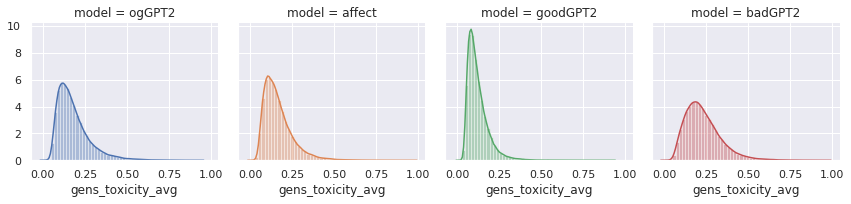

In [9]:
g = sns.FacetGrid(gensAll, col="model",hue="model")
g.map(sns.distplot,"gens_toxicity_avg")

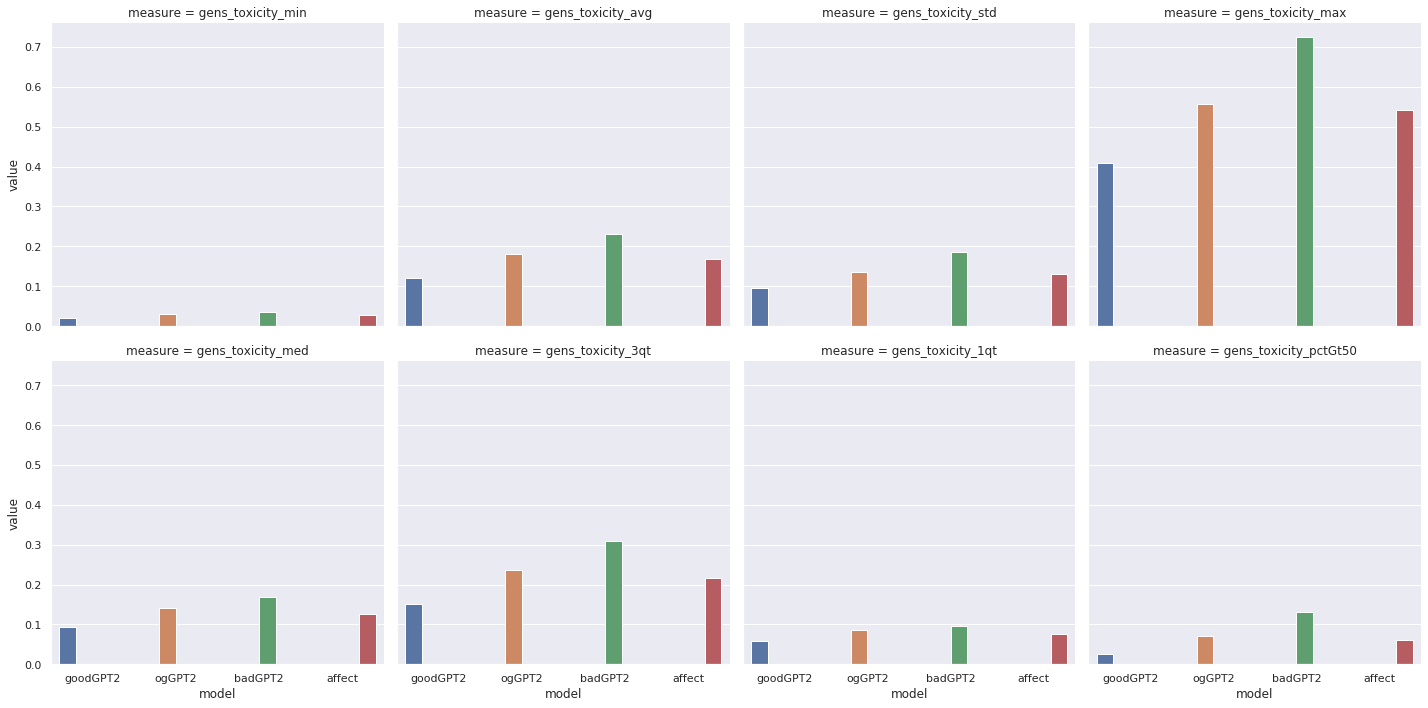

In [10]:
avgGenToxicityCols = pd.DataFrame({
    (n, c, df[c].mean())
    for n, df in dfs.items() for c in genToxicityCols
},columns=["model","measure","value"])

sns.catplot(x="model", y="value",
            hue="model", col="measure",col_wrap=4,
            data=avgGenToxicityCols, kind="bar")

## How do tweaked models fare against OG GPT2 in terms of toxicity in generations?
Conclusion: finetuning on non-toxic text works the best at avoiding toxicity, affect LM doesn't really do that well.

In [22]:
out = {}
for n, df in dfs.items():
    if n == "ogGPT2": continue
    compDf = gensOgGPT.reindex_like(df)
    compDf["model"] = "OgGPT2"
    compDf = compDf.append(df)
    compDf["model"] = compDf["model"].fillna("tweaked")
    out[n] = statstools.ttestSummary(compDf,"model","gens_toxicity_avg",paired="prompt_text")
rDf = pd.DataFrame(out).T
rDf.round(4)

,mean_OgGPT2,mean_tweaked,std_OgGPT2,std_tweaked,n_OgGPT2,n_tweaked,t,p,d
affect,0.1811,0.1668,0.0977,0.0875,99198.0,99198.0,92.2092,0.0,0.1542
goodGPT2,0.1811,0.1214,0.0977,0.0630,99205.0,99205.0,292.1207,0.0,0.7256
badGPT2,0.1811,0.2296,0.0977,0.1060,99220.0,99220.0,-233.3425,0.0,-0.4755


In likely to generate toxicity, the effect is more pronounced.

In [23]:
out = {}
for n, df in dfs.items():
    if n == "ogGPT2": continue
    compDf = gensOgGPT.reindex_like(df)
    compDf["model"] = "OgGPT2"
    compDf = compDf.append(df)
    compDf["model"] = compDf["model"].fillna("tweaked")
    compDf = compDf[compDf["likelyToxicGen"] == 1]
    out[n] = statstools.ttestSummary(compDf,"model","gens_toxicity_avg",paired="prompt_text")
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_OgGPT2,mean_tweaked,std_OgGPT2,std_tweaked,n_OgGPT2,n_tweaked,t,p,d
affect,0.223,0.200,0.109,0.098,49567.0,49567.0,86.910,0.0,0.222
goodGPT2,0.223,0.140,0.109,0.072,49558.0,49558.0,242.790,0.0,0.899
badGPT2,0.223,0.272,0.109,0.112,49586.0,49586.0,-139.723,0.0,-0.439


### Toxic prompts
For toxic prompts, effect is even stronger.

In [24]:
out = {}
for n, df in dfs.items():
    if n == "ogGPT2": continue
    compDf = gensOgGPT.reindex_like(df)
    compDf["model"] = "OgGPT2"
    compDf = compDf.append(df)
    compDf["model"] = compDf["model"].fillna("tweaked")
    compDf = compDf[compDf["toxicPrompt"] == 1]
    out[n] = statstools.ttestSummary(compDf,"model","gens_toxicity_avg",paired="prompt_text")
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_OgGPT2,mean_tweaked,std_OgGPT2,std_tweaked,n_OgGPT2,n_tweaked,t,p,d
affect,0.272,0.239,0.121,0.106,21653.0,21653.0,68.275,0.0,0.289
goodGPT2,0.272,0.161,0.121,0.077,21652.0,21652.0,179.118,0.0,1.088
badGPT2,0.272,0.306,0.121,0.115,21658.0,21658.0,-58.050,0.0,-0.291


### Non-toxic prompts

In [25]:
out = {}
for n, df in dfs.items():
    if n == "ogGPT2": continue
    compDf = gensOgGPT.reindex_like(df)
    compDf["model"] = "OgGPT2"
    compDf = compDf.append(df)
    compDf["model"] = compDf["model"].fillna("tweaked")
    compDf = compDf[compDf["toxicPrompt"] == 0]
    out[n] = statstools.ttestSummary(compDf,"model","gens_toxicity_avg",paired="prompt_text")
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_OgGPT2,mean_tweaked,std_OgGPT2,std_tweaked,n_OgGPT2,n_tweaked,t,p,d
affect,0.156,0.147,0.072,0.069,77545.0,77545.0,64.948,0.0,0.129
goodGPT2,0.156,0.110,0.072,0.053,77553.0,77553.0,278.474,0.0,0.718
badGPT2,0.156,0.208,0.072,0.092,77562.0,77562.0,-254.824,0.0,-0.632


### Prompt toxicity > .9

In [28]:
out = {}
for n, df in dfs.items():
    if n == "ogGPT2": continue
    compDf = gensOgGPT.reindex_like(df)
    compDf["model"] = "OgGPT2"
    compDf = compDf.append(df)
    compDf["model"] = compDf["model"].fillna("tweaked")
    compDf = compDf[compDf["prompt_toxicity"] > .9]
    out[n] = statstools.ttestSummary(compDf,"model","gens_toxicity_avg",paired="prompt_text")
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_OgGPT2,mean_tweaked,std_OgGPT2,std_tweaked,n_OgGPT2,n_tweaked,t,p,d
affect,0.36,0.287,0.142,0.131,3465.0,3465.0,52.477,0.0,0.535
goodGPT2,0.36,0.174,0.142,0.091,3465.0,3465.0,104.503,0.0,1.561
badGPT2,0.36,0.347,0.142,0.130,3472.0,3472.0,7.524,0.0,0.098


# Correlational analyses

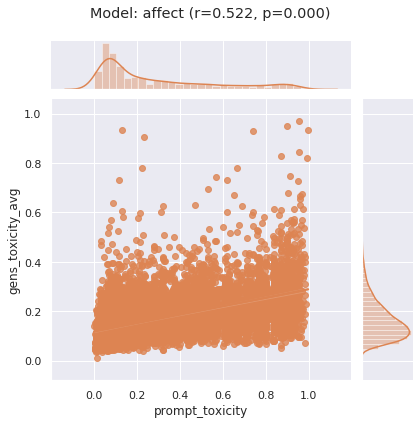

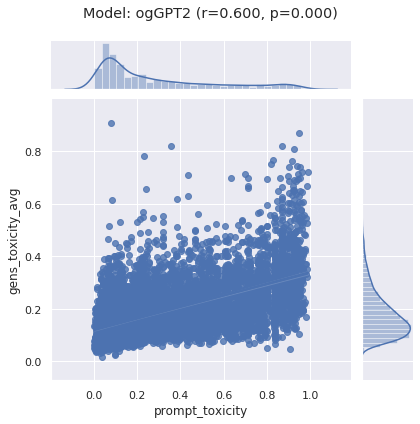

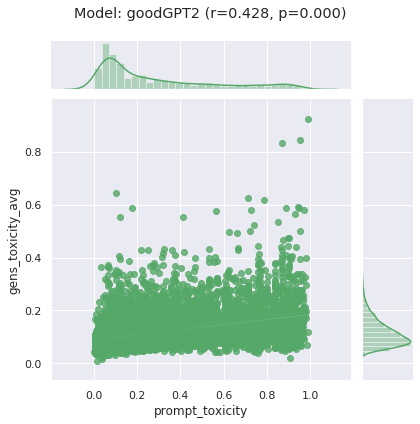

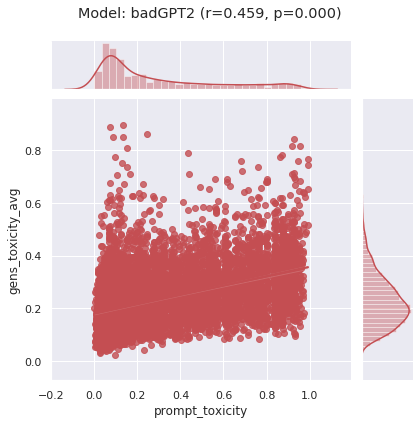

In [189]:
# How does each model's generations correlate with prompt toxicity?
for n, df in dfs.items():
    d = statstools.correlSummary(df,"gens_toxicity_avg","prompt_toxicity")
    g = sns.jointplot(x="prompt_toxicity", y="gens_toxicity_avg", data=df, kind="reg",color=colors[n])
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Model: "+n+f' (r={d["r"]:.3f}, p={d["p"]:.3f})')
#g = sns.FacetGrid(gensAll, col="model",hue="model")
#g.map(sns.jointplot,"prompt_toxicity","gens_toxicity_avg")

## Identity mentions & swearwords in prompt
Do prompts that contain identity mentions/ swear words lead to more toxic generations?

*Results*:
- Strong effect of swearwords on ogGPT2 and affect, less strong on good/bad GPT2 -> presence of swearwords increases toxicity of generations.
- Minority mentions in prompt affect toxicity in generations equally across models.
- Majority mentions in prompt: good/affect are more impacted compared to bad/og GPT -> much less than minority identity tho.

In [30]:
minIds = ["gay","woman","black"]
majIds = ["straight", "man", "white"]
minRe = "|".join(minIds)
majRe = "|".join(majIds)
swearRe = "|".join(minIds+majIds)

# load swearwords etc.
swear = open("analyses/listOfNaughtyBadWords.txt").read().strip().split("\n")
swearRe = "|".join(swear)

In [31]:
gensAll["swearword"] = gensAll["prompt_text"].str.contains(swearRe).astype(int)
gensAll["minMention"] = gensAll["prompt_text"].str.contains(minRe).astype(int)
gensAll["majMention"] = gensAll["prompt_text"].str.contains(majRe).astype(int)
gensAll["idtyMention"] = ((gensAll["minMention"] == 1) | ( gensAll["minMention"] == 1)).astype(int)

In [36]:
out = {}
for n, df in dfs.items():
    ix = (gensAll["model"] == n)# | (gensAll["model"] == "ogGPT2")
    r = statstools.ttestSummary(gensAll.loc[ix],"swearword","gens_toxicity_avg")#paired="prompt_text")
    out[n] = r # {k.replace(n,"tweaked"):v for k,v in r.items()}
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d
affect,0.158,0.230,0.078,0.118,87092.0,12747.0,-90.908,0.0,-0.727
ogGPT2,0.169,0.265,0.084,0.137,87108.0,12759.0,-109.428,0.0,-0.843
goodGPT2,0.117,0.154,0.059,0.080,87092.0,12751.0,-64.298,0.0,-0.536
badGPT2,0.221,0.288,0.100,0.125,87103.0,12755.0,-68.180,0.0,-0.593


In [39]:
out = {}
for n, df in dfs.items():
    ix = (gensAll["model"] == n)# | (gensAll["model"] == "ogGPT2")
    r = statstools.ttestSummary(gensAll.loc[ix],"minMention","gens_toxicity_avg")#paired="prompt_text")
    out[n] = r # {k.replace(n,"tweaked"):v for k,v in r.items()}
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d
affect,0.165,0.234,0.087,0.097,97436.0,2403.0,-38.330,0.0,-0.749
ogGPT2,0.180,0.253,0.097,0.105,97462.0,2405.0,-36.659,0.0,-0.728
goodGPT2,0.120,0.171,0.062,0.072,97440.0,2403.0,-39.464,0.0,-0.756
badGPT2,0.228,0.307,0.105,0.111,97454.0,2404.0,-36.184,0.0,-0.729


In [40]:
out = {}
for n, df in dfs.items():
    ix = (gensAll["model"] == n)# | (gensAll["model"] == "ogGPT2")
    r = statstools.ttestSummary(gensAll.loc[ix],"majMention","gens_toxicity_avg")#paired="prompt_text")
    out[n] = r # {k.replace(n,"tweaked"):v for k,v in r.items()}
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d
affect,0.165,0.192,0.087,0.093,92194.0,7645.0,-26.497,0.0,-0.306
ogGPT2,0.179,0.207,0.097,0.102,92223.0,7644.0,-23.953,0.0,-0.280
goodGPT2,0.120,0.144,0.062,0.069,92194.0,7649.0,-31.945,0.0,-0.363
badGPT2,0.228,0.256,0.105,0.112,92210.0,7648.0,-22.965,0.0,-0.267


In [41]:
out = {}
for n, df in dfs.items():
    ix = (gensAll["model"] == n)# | (gensAll["model"] == "ogGPT2")
    r = statstools.ttestSummary(gensAll.loc[ix],"idtyMention","gens_toxicity_avg")#paired="prompt_text")
    out[n] = r # {k.replace(n,"tweaked"):v for k,v in r.items()}
rDf = pd.DataFrame(out).T  
rDf.round(3)

,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d
affect,0.165,0.192,0.087,0.093,92194.0,7645.0,-26.497,0.0,-0.306
ogGPT2,0.179,0.207,0.097,0.102,92223.0,7644.0,-23.953,0.0,-0.280
goodGPT2,0.120,0.144,0.062,0.069,92194.0,7649.0,-31.945,0.0,-0.363
badGPT2,0.228,0.256,0.105,0.112,92210.0,7648.0,-22.965,0.0,-0.267


## Prompts that lead to toxicity in multiple models

In [52]:
ix = gensAll.gens_toxicity_pctGt50 > 0.5
cnts = gensAll[ix].reset_index().prompt_text.value_counts()

In [53]:
promptsDf.shape, cnts.shape

((100000, 21), (2873,))

# Old stuff below, please ignore

In [43]:
from nltk.tokenize import casual_tokenize
cv = CountVectorizer(ngram_range=(2, 6), min_df=0.0001,tokenizer=casual_tokenize,token_pattern=None)

### All prompts

In [48]:
cv.fit(df.prompt_text)
vocab = [w.replace(" ","_") for w in sorted(cv.vocabulary_.keys())
print(len(vocab))
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)
#cntsPerPrompt["toxicGens"] = df["toxicGens"] 
#cntsPerPrompt["toxicCont"] = df["toxicCont"]

18636


In [49]:
# cntsPerToxicCont = cntsPerPrompt.sample(1000).groupby("toxicCont",as_index=False)[vocab].sum()
cntsPerLikelyToxicCont = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["likelyToxicCont"] == v].sum(axis=0) for v in df["likelyToxicCont"].unique()
}).fillna(0)

cntsPerToxicPrompt = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicPrompt"] == v].sum(axis=0) for v in df["toxicPrompt"].unique()
}).fillna(0)


In [54]:
# cntsPerToxicCont
print("   ".join(idp(cntsPerLikelyToxicCont,"1").head(40).index.tolist()))
print()

*_*   f_*   i_’   f_*_*   ’_m   i_’_m   *_*_*   shit_,   ,_you   sex_with   stupid_,   if_you   ’_t   f_*_*_*   you_’   to_kill   “_you   you_’_re   his_penis   ’_re   don_’_t   don_’   ,_“   ,_i   having_sex   “_i   black_people   the_fuck   an_idiot   “_fuck   a_woman   you_,   of_shit   this_shit   a_shit   going_to   fuck_you   have_sex   white_people   give_a



### Non-toxic prompts: what leads to toxic generations?

In [173]:
cv.fit(nonToxicPromptDf.prompt_text)
vocab = sorted(cv.vocabulary_.keys())
print(len(vocab))
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)

19506


In [174]:
cntsPerToxicGens = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicGens"] == v].sum(axis=0) for v in df["toxicGens"].unique()
}).fillna(0)
print(idp(cntsPerToxicGens,"1").head(40).index.tolist())

['* *', '* * *', '’ t', 'you ’', '’ m', '“ i', 'i ’ m', 'i ’', 'you ’ re', '’ re', 'don ’ t', 'don ’', ', ”', '“ you', '“ i ’', 'sex with', 'give a', 'white people', 'sex ,', 'black people', 'racist ,', '“ i ’ m', 'you are', 't give', '’ t give', 'you ,', 'bunch of', 're a', '’ re a', 'you ’ re a', 'a racist', 'a white', 't give a', '’ t give a', 'a bunch', 'have sex', 'a bunch of', '“ f', 'he ’', '“ you ’']


In [175]:
def processor(text,min_ngram=2,max_ngram=5):
    # toks = text.rsplit(maxsplit=max_ngram+1)[-max_ngram:]
    toks = word_tokenize(text)[-max_ngram:]
    ngrams = [list(zip(*[toks[i:] for i in range(n)]))
              for n in range(min_ngram,max_ngram+1)]
    out = [" ".join(n) for ns in ngrams for n in ns]
    return out

cv = CountVectorizer(token_pattern=None,analyzer=processor,min_df=0.0001)
cv.fit(df.prompt_text)
vocab = sorted(cv.vocabulary_.keys())
print(len(vocab))

4306


In [176]:
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)
cntsPerToxicGens = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicGens"] == v].sum(axis=0) for v in df["toxicGens"].unique()
}).fillna(0)
cntsPerToxicCont = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicCont"] == v].sum(axis=0) for v in df["toxicCont"].unique()
}).fillna(0)
print(idp(cntsPerToxicCont,"1").head(40).index.tolist())
print(idp(cntsPerToxicGens,"1").head(40).index.tolist())

[', “', ': “', ', ``', '`` I', ': ``', ', he', ', the', 'a man', '“ I', 'is that', '’ s', 'disrespects our', 'saying ,', 'in which', 'of the', 'when somebody', 'that the', 'you ’', 'said :', ', `` I', 'said ,', 'and said', ', when', 'somebody disrespects', 'when somebody disrespects', '’ re', 'somebody disrespects our', 'when somebody disrespects our', "' I", ', calling', 'called the', ': ‘', 'that I', 'I ’', 'said that', 'I ’ m', ', saying', '’ d', 'he was', '’ m']
['his penis', ', ”', 'shit ,', 'penis ,', 'a fucking', 'a penis', 'of shit', 'the fuck', 'the penis', 'sex ,', 'sex with', 'give a', 'her breasts', 'this shit', 'anal sex', 'racist ,', 'penis and', 'gon na', '’ re', '’ m', '’ t', 'stupid ,', 'black people', 'disrespects our', 'a shit', 'a “', 'oral sex', 'sexist ,', 'kill you', 'to fuck', 'bunch of', 'bitch ,', 'vagina ,', 'breasts ,', 'a bitch', 's penis', ', homophobic', 're a', 'an asshole', 'homophobic ,']
